### Make Imports

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
import logging
import warnings
import joblib
import os

### Basic Logging and Warnings

In [2]:
# Basic logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Create directories for model artifacts
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

### Load the Dataset

In [3]:
# Load the dataset
# Load the abalone dataset
try:
    df = pd.read_csv("abalone/abalone.csv")
    logger.info(
        f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns"
    )
except Exception as e:
    logger.error(f"Error loading dataset: {e}")

2025-04-18 15:35:53,102 - __main__ - INFO - Dataset loaded successfully with 38295 rows and 9 columns


In [4]:
# Do basic checks and display head
# Display basic information
print("First five rows of the dataset:")
print(df.head())

print("\nBasic statistics:")
print(df.describe())

print("\nCheck for missing values:")
print(df.isnull().sum())

First five rows of the dataset:
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.330     0.200   0.095        0.1840          0.0904          0.0428   
1   I   0.475     0.390   0.169        0.6824          0.2463          0.1383   
2   F   0.545     0.405   0.128        0.7735          0.3456          0.1601   
3   F   0.610     0.490   0.169        1.1654          0.6199          0.2967   
4   F   0.520     0.380   0.145        0.6262          0.2624          0.1228   

   Shell weight  Rings  
0        0.0617      7  
1        0.1844      8  
2        0.2509     13  
3        0.2661     10  
4        0.2131     13  

Basic statistics:
             Length      Diameter        Height  Whole weight  Shucked weight  \
count  38295.000000  38295.000000  38295.000000  38295.000000    38295.000000   
mean       0.532398      0.414495      0.143926      0.843311        0.365464   
std        0.113254      0.090022      0.037448      0.453208        

### Data preprocessing and feature engineering

In [5]:
# define target and features
X = df.drop("Rings", axis=1)
y = df["Rings"]

In [6]:
# split the data into train and test sets 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

logger.info(f"Training set: {X_train.shape[0]} samples")
logger.info(f"Testing set: {X_test.shape[0]} samples")

2025-04-18 15:35:53,301 - __main__ - INFO - Training set: 30636 samples
2025-04-18 15:35:53,302 - __main__ - INFO - Testing set: 7659 samples


In [7]:
#  preprocess data for categorical and numerical features
categorical_features = ["Sex"]
numerical_features = X.columns.drop(categorical_features).tolist()

# create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

In [8]:
# feature engineering
def add_new_features(X):
    X_new = X.copy()

    # add volume
    X_new["Volume"] = X["Length"] * X["Diameter"] * X["Height"]

    # ratio measurements
    X_new["Length_to_Diameter"] = X["Length"] / X["Diameter"]
    X_new["Height_to_Diameter"] = X["Height"] / X["Diameter"]
    X_new["Shell_to_Total_Ratio"] = X["Shell weight"] / X["Whole weight"]

    # density approximations
    X_new["Density"] = X["Whole weight"] / X_new["Volume"]

    return X_new


# apply feature engineering
X_train_engineered = add_new_features(X_train)
X_test_engineered = add_new_features(X_test)

In [9]:
# update feature list
numerical_features_engineered = X_train_engineered.columns.drop(
    categorical_features
).tolist()
logger.info(
    f"Engineered features created, new total features: {len(numerical_features_engineered)}"
)

2025-04-18 15:35:53,474 - __main__ - INFO - Engineered features created, new total features: 12


In [10]:
# update preprocessor with engineered features
preprocessor_engineered = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features_engineered),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

### Model Training and Evaluation

In [11]:
# define helper function to evaluate models
def evaluate_model(model, X, y, model_name="Model"):
    """Evaluate model performance and return metrics"""

    y_pred = model.predict(X)

    # calculate metrics
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    # log metrics
    logger.info(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")

    return {"model_name": model_name, "mae": mae, "rmse": rmse, "r2": r2}

### Model Training

In [12]:
# define multiple models
models = {
    "Linear Regression": Pipeline([
        ("preprocessor", preprocessor_engineered),
        ("selector", SelectKBest(f_regression, k=8)),
        ("regressor", LinearRegression()),
    ]),
    "Ridge Regression": Pipeline([
        ("preprocessor", preprocessor_engineered),
        ("selector", SelectKBest(f_regression, k=8)),
        ("regressor", Ridge()),
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor_engineered),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessor", preprocessor_engineered),
        ("regressor", GradientBoostingRegressor(random_state=42)),
    ]),
    "MLP Regressor": Pipeline([
        ("preprocessor", preprocessor_engineered),
        ("regressor", MLPRegressor(hidden_layer_sizes=(100, 50), activation="relu", solver="adam", alpha=0.0001, max_iter=1000, random_state=42)),
    ]),
    "SVR": Pipeline([
        ("preprocessor", preprocessor_engineered),
        ("regressor", SVR(kernel="rbf", gamma="scale")),
    ]),

}

In [13]:
# train and evaluate each model
results = []
for name, model in models.items():
    logger.info(f"Training {name}...")
    model.fit(X_train_engineered, y_train)

    # evaluate model
    train_metrics = evaluate_model(model, X_train_engineered, y_train,f"{name} (Train)")
    test_metrics = evaluate_model(model, X_test_engineered, y_test,f"{name} (Test)")

    # append results
    results.append({
        "model_name": name,
        "train_mae": train_metrics["mae"],
        "test_mae": test_metrics["mae"],
        "train_rmse": train_metrics["rmse"],
        "test_rmse": test_metrics["rmse"],
        "train_r2": train_metrics["r2"],
        "test_r2": test_metrics["r2"],
    })

    # save the model
    joblib.dump(model, f"models/{name.replace(' ', '_').lower()}_initial.pkl")
    logger.info(f"{name} model saved.")

# convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

2025-04-18 15:35:53,729 - __main__ - INFO - Training Linear Regression...
2025-04-18 15:35:53,794 - __main__ - INFO - Linear Regression (Train) - MAE: 1.69, RMSE: 2.39, R^2: 0.35
2025-04-18 15:35:53,811 - __main__ - INFO - Linear Regression (Test) - MAE: 1.68, RMSE: 2.38, R^2: 0.35
2025-04-18 15:35:53,815 - __main__ - INFO - Linear Regression model saved.
2025-04-18 15:35:53,816 - __main__ - INFO - Training Ridge Regression...
2025-04-18 15:35:53,879 - __main__ - INFO - Ridge Regression (Train) - MAE: 1.69, RMSE: 2.39, R^2: 0.35
2025-04-18 15:35:53,898 - __main__ - INFO - Ridge Regression (Test) - MAE: 1.68, RMSE: 2.38, R^2: 0.35
2025-04-18 15:35:53,901 - __main__ - INFO - Ridge Regression model saved.
2025-04-18 15:35:53,902 - __main__ - INFO - Training Random Forest...
2025-04-18 15:36:38,019 - __main__ - INFO - Random Forest (Train) - MAE: 0.64, RMSE: 0.90, R^2: 0.91
2025-04-18 15:36:38,235 - __main__ - INFO - Random Forest (Test) - MAE: 1.71, RMSE: 2.39, R^2: 0.34
2025-04-18 15:36:

          model_name  train_mae  test_mae  train_rmse  test_rmse  train_r2  \
0  Linear Regression   1.693394  1.682469    2.389668   2.382091  0.347274   
1   Ridge Regression   1.693392  1.682462    2.389668   2.382085  0.347274   
2      Random Forest   0.641750  1.711645    0.901184   2.393484  0.907171   
3  Gradient Boosting   1.627286  1.635571    2.314032   2.343442  0.387939   
4      MLP Regressor   1.592688  1.595976    2.341049   2.364571  0.373564   
5                SVR   1.549520  1.549327    2.430037   2.432463  0.325035   

    test_r2  
0  0.350399  
1  0.350402  
2  0.344170  
3  0.371307  
4  0.359919  
5  0.322635  


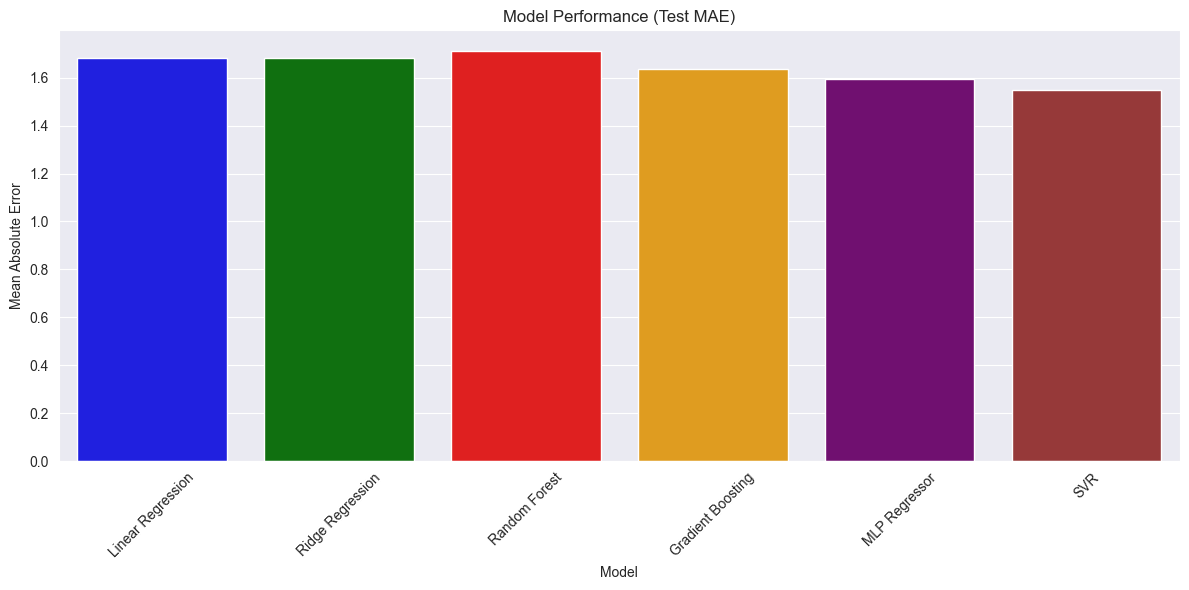

In [14]:
# Visualize results
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
sns.barplot(
    x="model_name",y="test_mae",data=results_df, palette=colors)
plt.title("Model Performance (Test MAE)")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/model_performance_test_mae.png")
plt.show()

### Hyperparameter Tuning

In [22]:
# select top three models
# current best models are Random Forest, Gradient Boosting, and MLP Regressor
models_to_tune = ["Random Forest", "Gradient Boosting", "MLP Regressor"]

logger.info(f"Selected {', '.join(models_to_tune)} for hyperparameter tuning.")

2025-04-18 17:30:30,009 - __main__ - INFO - Selected Random Forest, Gradient Boosting, MLP Regressor for hyperparameter tuning.


In [23]:
# define parameter grids for tuning
param_grids = {
    "Random Forest": {
        "regressor__n_estimators": [50,100,200],
        "regressor__max_depth": [None, 10, 20, 30],
        "regressor__min_samples_split": [2, 5, 10],
        "regressor__min_samples_leaf": [1, 2, 4],
    },
    "Gradient Boosting": {
        "regressor__n_estimators": [50, 100, 200],
        "regressor__learning_rate": [0.01, 0.05 ,0.1],
        "regressor__max_depth": [3, 5, 7],
        "regressor__min_samples_split": [2, 5],
    },
    "MLP Regressor": {
        "regressor__hidden_layer_sizes": [(50,), (100,),(50, 25), (100, 50)],
        "regressor__activation": ["relu", "tanh"],
        "regressor__alpha": [0.0001, 0.001, 0.01],
        "regressor__learning_rate_init": [0.001, 0.01],
    }
}

# store tuning results
tuning_results = {}
best_scores = {}
best_models = {}

In [24]:
# perform hyperparameter tuning

for model_name in models_to_tune:
    logger.info(f"Starting hyperparameter tuning for {model_name}...")

    # create grid search cv
    grid_search = GridSearchCV(
        models[model_name],
        param_grids[model_name],
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=2,
    )

    # fit grid search
    grid_search.fit(X_train_engineered, y_train)

    # display best parameters and score
    logger.info(f"{model_name} - Best parameters: {grid_search.best_params_}")
    logger.info(f"{model_name} - Best cross-validation MAE: {grid_search.best_score_:.2f}")

    # get the best model
    best_model = grid_search.best_estimator_

    # evaluate the tuned model
    train_metrics = evaluate_model(best_model, X_train_engineered, y_train,f"{model_name} (Train)")
    test_metrics = evaluate_model(best_model, X_test_engineered, y_test,f"{model_name} (Test)")

    # store results
    tuning_results[model_name] = {
        "best_params": grid_search.best_params_,
        "train_mae": train_metrics["mae"],
        "test_mae": test_metrics["mae"],
        "train_rmse": train_metrics["rmse"],
        "test_rmse": test_metrics["rmse"],
        "train_r2": train_metrics["r2"],
        "test_r2": test_metrics["r2"],
        "cv_score": grid_search.best_score_,
    }

    best_scores[model_name] = test_metrics["mae"]
    best_models[model_name] = best_model

    # save the best model
    joblib.dump(best_model, f"models/{model_name.replace(' ', '_').lower()}_tuned.pkl")
    logger.info(f"{model_name} tuned model saved.")

# determine overall best model
best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
logger.info(f"Best model after tuning: {best_model_name} with MAE: {best_scores[best_model_name]:.2f}")

best_train_metrics = evaluate_model(best_model, X_train_engineered, y_train,f"{best_model_name} Tuned (Train)")
best_test_metrics = evaluate_model(best_model, X_test_engineered, y_test,f"{best_model_name} Tuned (Test)")

2025-04-18 17:30:30,764 - __main__ - INFO - Starting hyperparameter tuning for Random Forest...


Fitting 5 folds for each of 108 candidates, totalling 540 fits


2025-04-18 18:48:56,833 - __main__ - INFO - Random Forest - Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
2025-04-18 18:48:56,836 - __main__ - INFO - Random Forest - Best cross-validation MAE: -1.66
2025-04-18 18:48:57,384 - __main__ - INFO - Random Forest (Train) - MAE: 1.50, RMSE: 2.14, R^2: 0.48
2025-04-18 18:48:57,568 - __main__ - INFO - Random Forest (Test) - MAE: 1.64, RMSE: 2.34, R^2: 0.37
2025-04-18 18:48:57,658 - __main__ - INFO - Random Forest tuned model saved.
2025-04-18 18:48:57,658 - __main__ - INFO - Starting hyperparameter tuning for Gradient Boosting...


Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-18 19:03:14,173 - __main__ - INFO - Gradient Boosting - Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
2025-04-18 19:03:14,174 - __main__ - INFO - Gradient Boosting - Best cross-validation MAE: -1.65
2025-04-18 19:03:14,241 - __main__ - INFO - Gradient Boosting (Train) - MAE: 1.62, RMSE: 2.32, R^2: 0.39
2025-04-18 19:03:14,267 - __main__ - INFO - Gradient Boosting (Test) - MAE: 1.64, RMSE: 2.35, R^2: 0.37
2025-04-18 19:03:14,278 - __main__ - INFO - Gradient Boosting tuned model saved.
2025-04-18 19:03:14,278 - __main__ - INFO - Starting hyperparameter tuning for MLP Regressor...


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/souls/Math448/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/souls/Math448/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/souls/Math448/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/souls/Math448/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/souls/Mat

In [25]:
# compare initial and tuned models
tuned_results = []

# add initial results

for model_name in models_to_tune:
    tuned_results.append({
        'model_name': f"{model_name} (Initial)",
        'test_mae': results_df[results_df['model_name'] == model_name]['test_mae'].values[0],
        'test_r2': results_df[results_df['model_name'] == model_name]['test_r2'].values[0],
    })

    # add tuned results
    tuned_results.append({
        'model_name': f"{model_name} (Tuned)",
        'test_mae': tuning_results[model_name]['test_mae'],
        'test_r2': tuning_results[model_name]['test_r2'],
    })

# convert to DataFrame
tuned_df = pd.DataFrame(tuned_results)
print(tuned_df)

                    model_name  test_mae   test_r2
0      Random Forest (Initial)  1.711645  0.344170
1        Random Forest (Tuned)  1.636576  0.371834
2  Gradient Boosting (Initial)  1.635571  0.371307
3    Gradient Boosting (Tuned)  1.635307  0.369561
4      MLP Regressor (Initial)  1.595976  0.359919
5        MLP Regressor (Tuned)  1.625439  0.360677


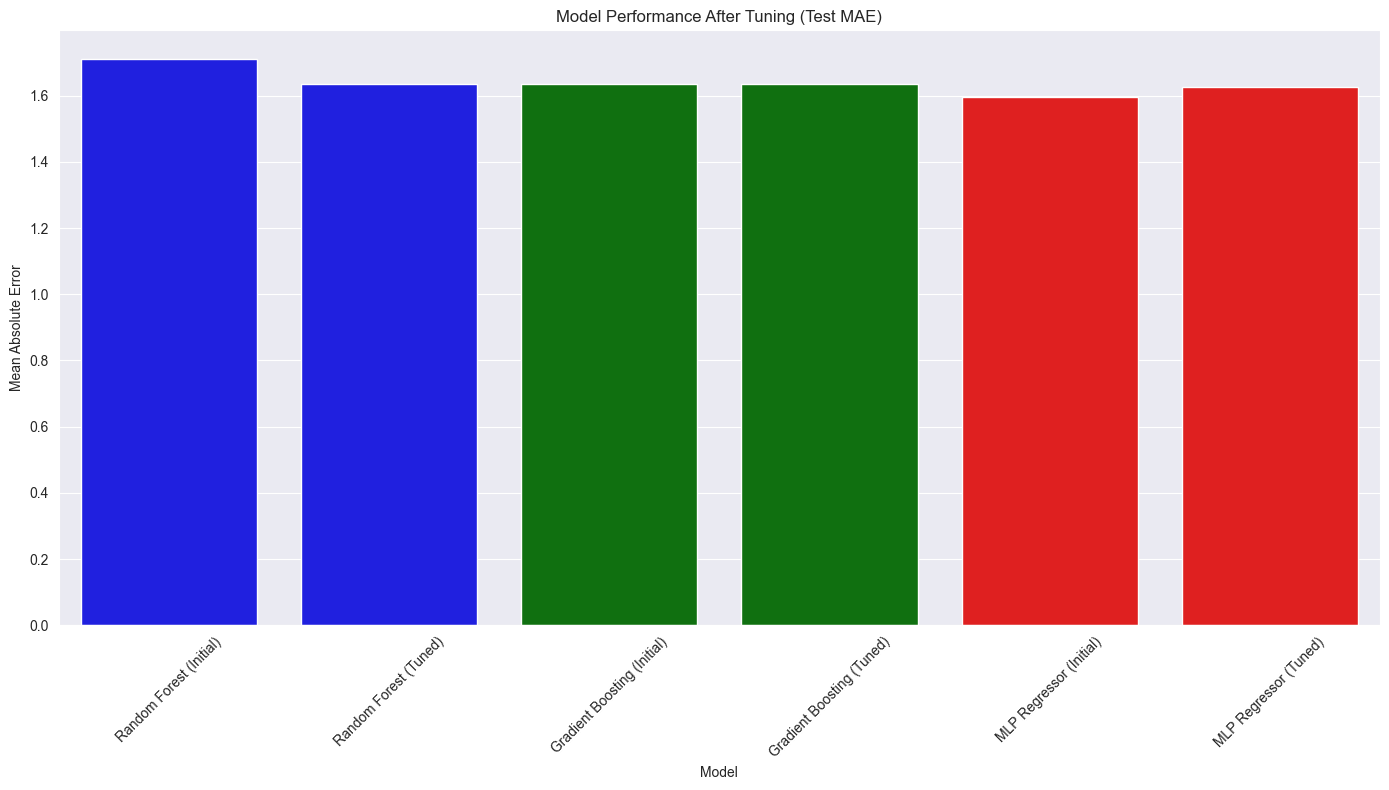

In [28]:
# Visualize tuned results
plt.figure(figsize=(14,8))
tuned_colors = ['blue', 'blue', 'green', 'green', 'red', 'red']
sns.barplot(
    x="model_name",y="test_mae",data=tuned_df, palette=tuned_colors)
plt.title("Model Performance After Tuning (Test MAE)")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/tuned_model_performance_test_mae.png")
plt.show()

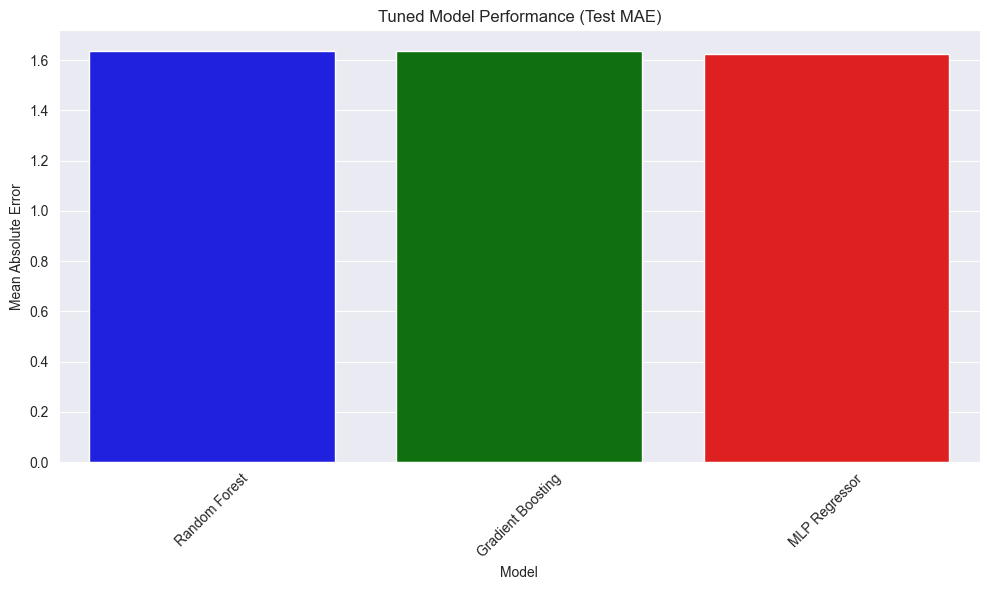

In [30]:
# create comparison for only tuned models
tuned_models_comparison = pd.DataFrame([
    {
        'model_name': model_name,
        'test_mae': tuning_results[model_name]['test_mae'],
        'test_r2': tuning_results[model_name]['test_r2'],
    } for model_name in models_to_tune
])

plt.figure(figsize=(10,6))
only_tuning_colors = ['blue', 'green', 'red']
sns.barplot(
    x="model_name",y="test_mae",data=tuned_models_comparison, palette=only_tuning_colors)
plt.title("Tuned Model Performance (Test MAE)")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/tuned_models_comparison_test_mae.png")
plt.show()

### Final Model Training and Evaluation

In [31]:
# train the model on entire dataset
logger.info(f"Training final model using best tuned model: {best_model_name}")

2025-04-18 19:36:53,304 - __main__ - INFO - Training final model using best tuned model: MLP Regressor


In [32]:
# create new final model

best_params = tuning_results[best_model_name]['best_params']
final_model = Pipeline([
    ("preprocessor", preprocessor_engineered),
    ("regressor", MLPRegressor(
        hidden_layer_sizes=best_params['regressor__hidden_layer_sizes'],
        activation=best_params['regressor__activation'],
        alpha=best_params['regressor__alpha'],
        learning_rate_init=best_params['regressor__learning_rate_init'],
        max_iter=2000,
        random_state=42,
    ))
])

logger.info(f"Final model parameters: {best_params}")

2025-04-18 19:38:42,421 - __main__ - INFO - Final model parameters: {'regressor__activation': 'relu', 'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (50, 25), 'regressor__learning_rate_init': 0.01}


In [33]:
# train on entire dataset
X_full_engineered = add_new_features(X)
final_model.fit(X_full_engineered, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight', 'Volume',
                                                   'Length_to_Diameter',
                                                   'Height_to_Diameter',
                                                   'Shell_to_Total_Ratio',
                                                   'Density']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex'])])),
                ('regressor',
                 MLPRegressor(alpha=0.001, hidden_layer_sizes=(50, 25),
                              learning_rate_init=0.01, max_iter=2000,
                              random_state=42))])

In [34]:
# perform cross-validation to estimate performance
cv_scores = cross_val_score(final_model, X_full_engineered, y, cv=5, scoring="neg_mean_absolute_error")

logger.info(f"Cross-validation MAE: {cv_scores}")
logger.info(f"Mean CV MAE: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# save the final model
joblib.dump(final_model, "models/final_model.pkl")
logger.info("Final model saved.")

2025-04-18 19:42:07,126 - __main__ - INFO - Cross-validation MAE: [-1.72659917 -1.61298447 -1.67222215 -1.66569081 -1.64863613]
2025-04-18 19:42:07,127 - __main__ - INFO - Mean CV MAE: -1.67 ± 0.04
2025-04-18 19:42:07,136 - __main__ - INFO - Final model saved.


### Feature Importance Analysis

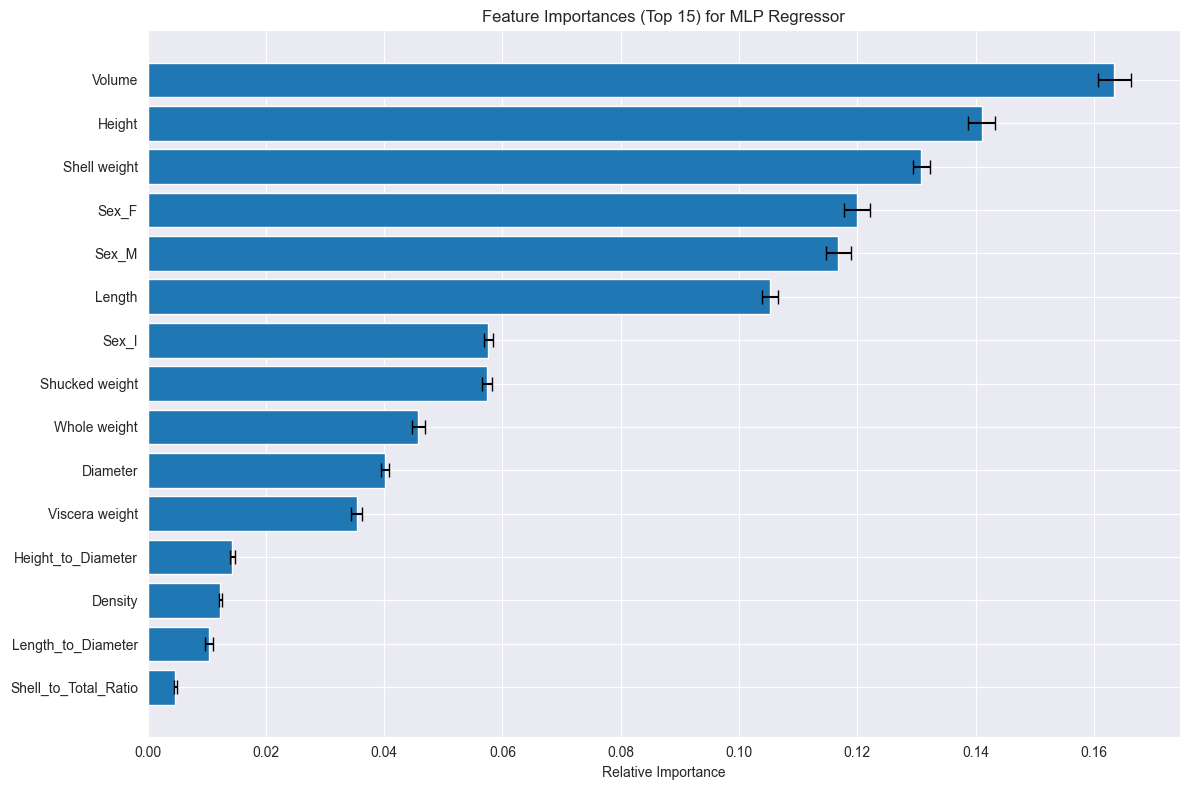

Feature importance ranking for MLP Regressor:
                 Feature  Importance    StdDev
7                 Volume    0.163463  0.002807
2                 Height    0.141014  0.002229
6           Shell weight    0.130836  0.001446
12                 Sex_F    0.119985  0.002146
14                 Sex_M    0.116816  0.002115
0                 Length    0.105232  0.001328
13                 Sex_I    0.057631  0.000800
4         Shucked weight    0.057378  0.000845
3           Whole weight    0.045787  0.001072
1               Diameter    0.040114  0.000615
5         Viscera weight    0.035354  0.000924
9     Height_to_Diameter    0.014332  0.000435
11               Density    0.012254  0.000258
8     Length_to_Diameter    0.010350  0.000701
10  Shell_to_Total_Ratio    0.004652  0.000242


In [38]:
# perform feature import analysis
X_full_engineered_processed = preprocessor_engineered.fit_transform(X_full_engineered)

# get feature names
cat_features = preprocessor_engineered.transformers_[1][2]
cat_encoder = preprocessor_engineered.named_transformers_['cat']

# get one-hot encoded feature names
if hasattr(cat_encoder, 'get_feature_names_out'):
    cat_feature_names = cat_encoder.get_feature_names_out(cat_features)
else:
    cat_feature_names = [f"{cat_features[0]}_{cat}" for cat in ['M', 'F', 'I']]

# combine with numerical features
num_features = preprocessor_engineered.transformers_[0][2]
feature_names = list(num_features) + list(cat_feature_names)

fitted_regressor = final_model[-1]

# Calculate permutation importance
perm_importance = permutation_importance(
    fitted_regressor, X_full_engineered_processed, y,
    n_repeats=10, random_state=42, n_jobs=-1
)

importances = perm_importance.importances_mean
importance_std = perm_importance.importances_std

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'StdDev': importance_std
}).sort_values('Importance', ascending=False)

# Display top 15 features
indices = np.argsort(importances)[-15:]
plt.figure(figsize=(12, 8))
plt.title(f'Feature Importances (Top 15) for {best_model_name}')
plt.barh(range(len(indices)), importances[indices], align='center',
         xerr=importance_std[indices], capsize=5)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('plots/feature_importance.png')
plt.show()

print(f"Feature importance ranking for {best_model_name}:")
print(feature_importance_df.head(15))

### Visualize predictions vs actual values

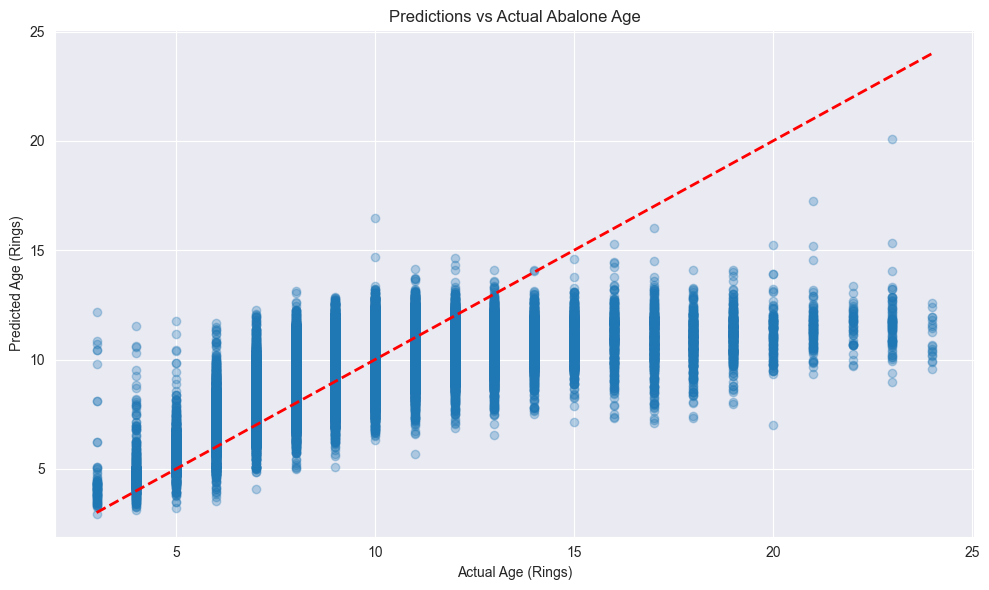

In [44]:
y_pred = final_model.predict(X_full_engineered)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title(f"Predictions vs Actual Abalone Age")
plt.xlabel("Actual Age (Rings)")
plt.ylabel("Predicted Age (Rings)")
plt.tight_layout()
plt.savefig('plots/predictions_vs_actual.png')
plt.show()

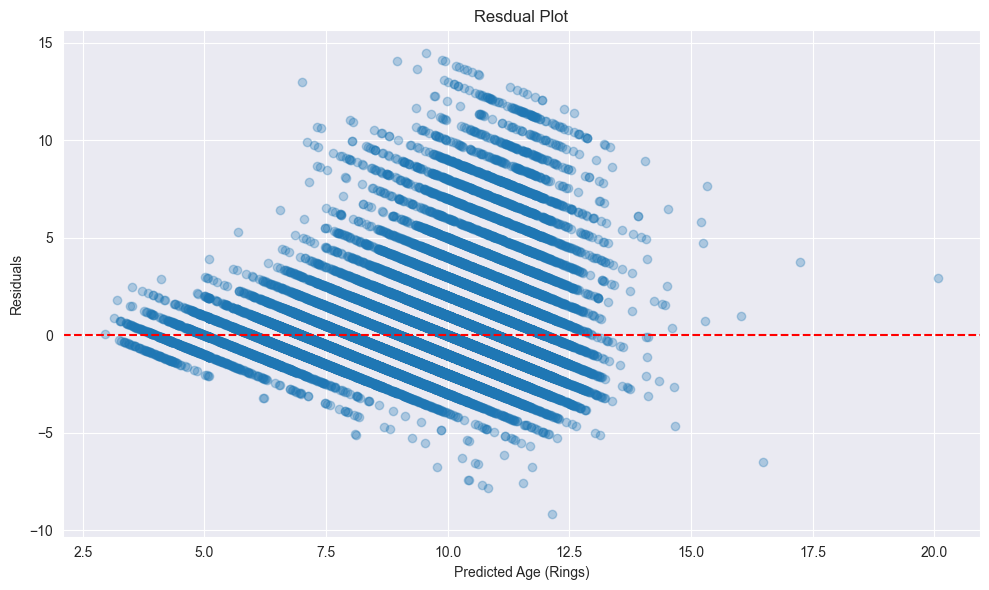

In [45]:
# residual plot
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Resdual Plot")
plt.xlabel("Predicted Age (Rings)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig('plots/residual_plot.png')
plt.show()

### Summary of model performance

In [49]:
print("Final Abalone Age Prediction Model Summary")
print("=" * 50)
print(f"Model: {best_model_name} with optimized hyperparameters")
print(f"Mean Absolute Error (Cross-Validation): {-cv_scores.mean():.2f} rings")
print(f"Standard Deviation of MAE (Cross-Validation): {cv_scores.std():.2f} rings")
print(f"Mean Absolute Error (Full Dataset): {mean_absolute_error(y, y_pred):.2f} rings")
print(f"Root Mean Squared Error (Full Dataset): {np.sqrt(mean_squared_error(y, y_pred)):.2f} rings")
print(f"R² Score (Full Dataset): {r2_score(y, y_pred):.2f}")
print("=" * 50)

# Compare all tuned models' performance
print("\nComparison of All Tuned Models:")
print("-" * 40)
for model_name in models_to_tune:
    print(f"{model_name}: MAE = {tuning_results[model_name]['test_mae']:.2f}, R² = {tuning_results[model_name]['test_r2']:.2f}")
print("-" * 40)

# Print feature importance
print(feature_importance_df.head(15))

Final Abalone Age Prediction Model Summary
Model: MLP Regressor with optimized hyperparameters
Mean Absolute Error (Cross-Validation): 1.67 rings
Standard Deviation of MAE (Cross-Validation): 0.04 rings
Mean Absolute Error (Full Dataset): 1.60 rings
Root Mean Squared Error (Full Dataset): 2.34 rings
R² Score (Full Dataset): 0.37

Comparison of All Tuned Models:
----------------------------------------
Random Forest: MAE = 1.64, R² = 0.37
Gradient Boosting: MAE = 1.64, R² = 0.37
MLP Regressor: MAE = 1.63, R² = 0.36
----------------------------------------
                 Feature  Importance    StdDev
7                 Volume    0.163463  0.002807
2                 Height    0.141014  0.002229
6           Shell weight    0.130836  0.001446
12                 Sex_F    0.119985  0.002146
14                 Sex_M    0.116816  0.002115
0                 Length    0.105232  0.001328
13                 Sex_I    0.057631  0.000800
4         Shucked weight    0.057378  0.000845
3           Whol